# HVGs and Cell Type

## Outline

The **MLAging - batch integration and misc ** workflow consists of sections:

`60 preprocessing_batch.R` Data preprocessing and preparation in Seurat.

`61 Batch Integration Scheme ELN Tuning` Scheme: batch effects within training or test sets. ELN model tunning using highly variable genes (HVGs) and hyperparameter selection using `GridSearchCV`.

`62 Batch Integration Scheme ELN Result 10x` Run the best ELN model over 10 random seeds.

`63 HVG and Cell Type` Clustering and heatmap showing that HVGs are cell type-specific -- **this notebook**:

`64 AUROC Results` ELN 10x results shown in AUPRC metric.

`65 age_genes.R` Aging database queries.

In [1]:
from src.data_processing import *
from src.grid_search import *
from src.packages import *

import scipy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import pylab
from scipy.misc import derivative


## 1. Data Preparation <a name="1.-prep"></a>
### Load training, testing batch

In [2]:
input_train = '../../MLAging/data/train_final_group_info.csv'
train_df = pd.read_csv(input_train, index_col=0)

train_df.set_index('major_group', inplace=True)
train_df = train_df.loc[list(train_df.index.unique())]

train_bin = binarize_data(train_df.iloc[:,0:1413])
train_bin

,Avp,Pmch,Oxt,Hcrt,Sst,Cartpt,Pomc,Trh,Tac2,Npy,...,Fgd5,Slc7a8,Gm7967,Prkcg,Cfap47,Nos1ap,Wwc1,Gm48727,Mgll,Sytl2
major_group,,,,,,,,,,,,,,,,,,,,,
Neuron,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
Neuron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
Neuron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
Neuron,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Neuron,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Macrophage,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Macrophage,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Macrophage,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


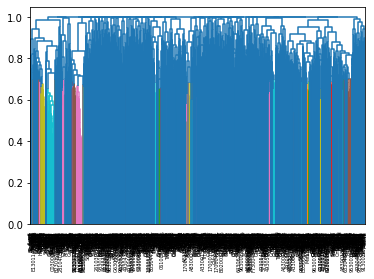

In [29]:
train_bin = binarize_data(train_df.iloc[:,0:1413])
train_bin

correlations = train_bin.corr()
dissimilarity = 1 - abs(correlations)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=train_bin.columns, orientation='top', 
           leaf_rotation=90);
threshold = 0.8
labels = fcluster(Z, threshold, criterion='distance')

labels_order = np.argsort(labels)
data = train_bin.iloc[:,0:1413]
# Build a new dataframe with the sorted columns
for idx, i in enumerate(data.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(data[i])
    else:
        df_to_append = pd.DataFrame(data[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

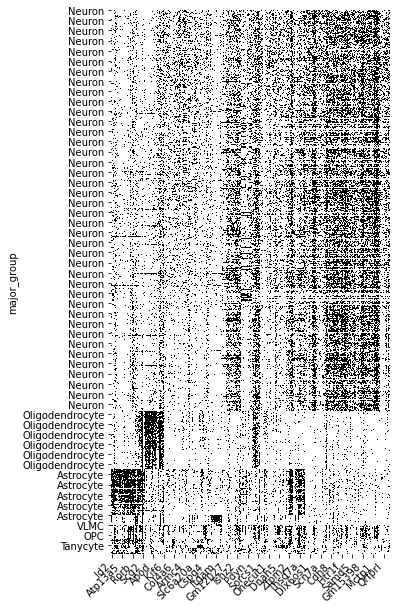

In [30]:
plt.figure(figsize=(5, 10))

ax = sns.heatmap(
    train_bin.loc[:, list(clustered.columns)], 
    cmap = sns.color_palette(["white", "black"]),
    square=False,
    cbar=False
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.savefig('hvg_train_heatmap_bin.pdf', bbox_inches='tight')
plt.show()

In [34]:
input_test = '../../MLAging/data/test_final_group_info.csv'
test_df = pd.read_csv(input_test, index_col=0)

test_df.set_index('major_group', inplace=True)
test_df = test_df.loc[list(test_df.index.unique())]

test_bin = binarize_data(test_df.iloc[:,0:1413])
test_bin

,Avp,Pmch,Oxt,Hcrt,Sst,Cartpt,Pomc,Trh,Tac2,Npy,...,Fgd5,Slc7a8,Gm7967,Prkcg,Cfap47,Nos1ap,Wwc1,Gm48727,Mgll,Sytl2
major_group,,,,,,,,,,,,,,,,,,,,,
Neuron,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Neuron,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Neuron,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Neuron,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
Neuron,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Macrophage,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Macrophage,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Macrophage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


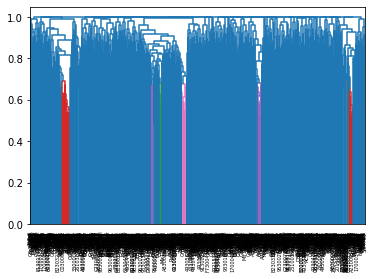

In [35]:
correlations = test_bin.corr()
dissimilarity = 1 - abs(correlations)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=test_bin.columns, orientation='top', 
           leaf_rotation=90);
threshold = 0.8
labels = fcluster(Z, threshold, criterion='distance')

labels_order = np.argsort(labels)
data = test_bin.iloc[:,0:1413]
# Build a new dataframe with the sorted columns
for idx, i in enumerate(data.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(data[i])
    else:
        df_to_append = pd.DataFrame(data[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

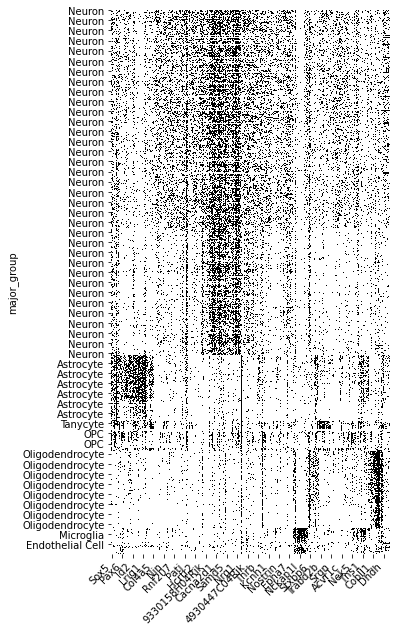

In [37]:
plt.figure(figsize=(5, 10))

ax = sns.heatmap(
    test_bin.loc[:, list(clustered.columns)], 
    cmap = sns.color_palette(["white", "black"]),
    square=False,
    cbar=False
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.savefig('hvg_test_heatmap_bicn.pdf', bbox_inches='tight')
plt.show()